In [1]:
%matplotlib inline
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cubedsphere as cs
import xesmf as xe

import warnings; warnings.filterwarnings("ignore")

# Read GCHP cubedsphere data

Same as [GCHP_plot.ipynb](./GCHP_plot.ipynb)

In [2]:
maindir = "./sample_data/"  # change to your data folder
ds = xr.open_dataset(maindir+"./GCHP.inst.20130708_0000z.nc4")

In [3]:
data = ds['RadDecay_Be7'].isel(time=0, lev=0).data
data = data.reshape(6, 24, 24)

In [4]:
data[3].flags

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  UPDATEIFCOPY : False

In [5]:
grid = cs.csgrid_GMAO(24)  # compute coordinate values

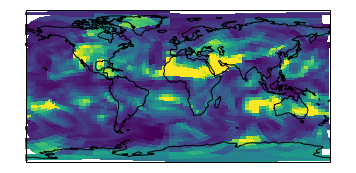

In [6]:
fig = plt.figure(figsize=[6, 4])
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
cs.plotCS_quick_raw(grid['lon_b'], grid['lat_b'],
                    data, grid['lon'], ax,
                    vmin=0, vmax=2e-15)

# Compute coordinate values for xESMF

xESMF can take work with either xarray or pure numpy arrays: http://xesmf.readthedocs.io/en/latest/Pure_numpy.html

Here we use pure numpy, which is more transparent. The input and output grid are simply dictionaries.

In [7]:
# Compute GEOS-Chem grid, with half-polar cell
# http://wiki.seas.harvard.edu/geos-chem/index.php/GEOS-Chem_horizontal_grids#GMAO_4_x_5_grid
lon_b = np.linspace(-182.5, 177.5, 73, endpoint=True)
lat_b = np.linspace(-92, 92, 47, endpoint=True).clip(-90,90)
lat = (lat_b[1:]+lat_b[:-1])/2
lon = (lon_b[1:]+lon_b[:-1])/2
grid_LL = {'lat': lat, 'lon': lon, 'lat_b': lat_b, 'lon_b': lon_b}

Cubedsphere data can be regridded tile-by-tile. We make 6 dictionaries for 6 tiles.

In [8]:
grid_CS_list = [None]*6
for i in range(6):
    grid_CS_list[i] = {'lat': grid['lat'][i], 'lon': grid['lon'][i],
                       'lat_b': grid['lat_b'][i], 'lon_b': grid['lon_b'][i]}


# Regrid

In [10]:
def regrid(ds_in, ds_out, dr_in, filename=None):
    """Convenience function for one-time regridding"""
    regridder = xe.Regridder(ds_in, ds_out, method='conservative',
                             filename=filename, reuse_weights=True)
    dr_out = regridder(dr_in)
    # keep weights on the disk for next time
    # regridder.clean_weight_file() 
    
    return dr_out

def C2L(grid_CS_list, grid_LL, data_CS):
    '''
    Regrid Cubedsphere to LatLon
    '''
    data_out = np.zeros([grid_LL['lat'].size, grid_LL['lon'].size])
    for i in range(6):
        # add up the results for 6 tiles
        data_out += regrid(grid_CS_list[i], grid_LL, data_CS[i],
                              filename='weights_tile{0}.nc'.format(i+1))
    
    return data_out

In [11]:
data_LL = C2L(grid_CS_list, grid_LL, data)

Reuse existing file: weights_tile1.nc
Reuse existing file: weights_tile2.nc
Reuse existing file: weights_tile3.nc
Reuse existing file: weights_tile4.nc
Reuse existing file: weights_tile5.nc
Reuse existing file: weights_tile6.nc


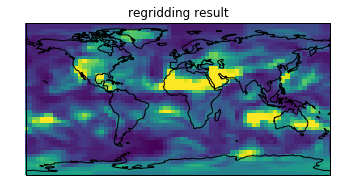

In [12]:
fig = plt.figure(figsize=[6, 4])
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.pcolormesh(grid_LL['lon_b'], grid_LL['lat_b'], data_LL, vmin=0, vmax=2e-15)
ax.set_title('regridding result')